# Solana and Ethereum Liquidity Pool Analysis

This notebook fetches and analyzes liquidity pool data from decentralized exchanges (DEXes) on Solana and Ethereum blockchains using the GeckoTerminal API. It allows interactive selection of chains, DEXes, and filtering parameters such as TVL and volume ranges.

## Setup
Install dependencies and import required modules.

In [1]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from src.clients.geckoterminal import GeckoTerminalClient
from src.constants import Network, NETWORK_CONFIG
from datetime import datetime, timedelta
import os
import glob
import numpy as np
import traceback

# Import everything from the consolidated utils.py
from src.utils import *

# Initialize styles for better output display
display(HTML('<style>.output {max-height: 500px; overflow-y: auto;}</style>'))

# Define available chains and DEXes
chains = [Network.SOLANA.value, Network.ETHEREUM.value, Network.BSC.value, Network.POLYGONPOS.value,
          Network.ARBITRUM.value, Network.SUI.value, Network.BASE.value]
dexes_by_chain = {
    chain: NETWORK_CONFIG[chain]['dexes'] for chain in chains
}

## Select parameters for pool research

In [7]:
# Parameters for pool fetching
selected_chains = [Network.SOLANA.value]  # Example: [Network.SOLANA.value, Network.ETHEREUM.value]
selected_dexes = []  # Leave empty to fetch all DEXes for the chains, or specify e.g., ['meteora', 'uniswap_v3']
min_tvl = 50000  # Minimum TVL in USD
max_tvl = 100000  # Maximum TVL in USD
min_volume = 1000  # Minimum 24h volume in USD
min_volume_tvl_ratio = 2  # Minimum 24h Volume / TVL ratio 
no_pivots = False  # Exclude pools with pivot tokens (e.g., SOL, ETH)
no_stables = True  # Exclude stablecoin pools
utility_pairs = False  # Fetch only utility pairs (e.g., SOL with DEX tokens)
force_redownload = False  # Force re-download of price data if True

# Parameters for price fetching
use_all_pools = True  # Use all fetched pools; if False, specify selected_pools below
selected_pools = []  # List of pool strings like ['solana/meteora/POPCAT/FWOG (CYTYHaAR...)']; ignored if use_all_pools=True
start_timestamp = int((datetime.now() - timedelta(days=30)).timestamp())  # Last 30 days
end_timestamp = int(datetime.now().timestamp())

# Parameters for analysis
min_tvl_threshold = 30000  # Minimum TVL for LP opportunities
min_volume_threshold = 40000  # Minimum 7-day avg daily volume for LP opportunities
min_fees_tvl_ratio_threshold = 0.005  # Minimum 7-day avg daily fees-to-TVL ratio for LP opportunities
min_volume_tvl_ratio_threshold = 2  # Minimum 7-day avg daily volume-to-TVL ratio for LP opportunities
fee_rate = 0.003  # Default fee rate for calculations (overridden by API-fetched fee tiers)

## Fetch Liquidity Pools

This cell fetches liquidity pool data from the GeckoTerminal API for the specified chains and DEXes. It applies filters for TVL, 24h volume, and Volume/TVL ratio, removes duplicates, and saves the results to a CSV file (`pools_multi_YYYYMMDD.csv`). It also visualizes TVL and volume distributions and prepares a list of pool options for price fetching.

Processing chain: solana
Fetching from DEX: raydium on chain solana
Fetched 23 pools from raydium on solana
Fetching from DEX: meteora on chain solana
Fetched 17 pools from meteora on solana
Fetching from DEX: orca on chain solana
Fetched 10 pools from orca on solana
Total pools before dedup: 50
Total pools after dedup: 50
Total pools after Volume/TVL ratio filter (>= 2): 46
Displaying 46 pools (with Volume/TVL ratio):


,Chain,DEX,Pair,TVL,24hVolume,Address,Volume_TVL_Ratio
0,solana,raydium,GrokCLI/SOL,67661.0705,1.042832e+07,B3zEeicgmHKpvsPs2fpVqaGyFfezmXh6hBTzCnfEQxLf,154.125869
1,solana,raydium,OpticXT/SOL,93368.2190,8.261727e+06,4NiCVAfwJsCmr9voYZcDwGG8fqsWx39BPTWjfN8TjMeF,88.485431
2,solana,raydium,Chloe/SOL,85217.6979,7.890781e+06,DainmLHoRDb2pK5WM2Ne9hXWDBRsuizVvy7dbYbK7WJ9,92.595561
3,solana,raydium,TiA/SOL,54098.2434,4.846312e+06,AKT2onG6bvX3jx93x9XBThSHER32L4PBnbjLqGRrsnZf,89.583541
4,solana,raydium,Altman/SOL,83028.2733,4.798638e+06,FhTkfTRtMWesuTfNSbnCQiZmcX2mCT9izy4zSEPXYf6T,57.795223
5,solana,raydium,nft/SOL,77914.4255,4.290420e+06,EsW7KfGwmaNwbaxG1AqdpQviuWnPUHmTiaHXnerqw3ix,55.065792
6,solana,raydium,craite/SOL,55053.6504,3.589706e+06,5ox37w3a9MXT8BiBsj1wXyZnrJMdpF1z2vUxbfgMmCZV,65.203775
7,solana,raydium,GABRIEL/SOL,52125.8576,2.808285e+06,DKv7eb6X8qY1HtkMaDYSE6rdjSs6iyT5hNc6w7nEiFz7,53.875085
8,solana,raydium,Load/SOL,56887.9228,2.797597e+06,G33LWhfZSDLD9GJRvSYAJ6bEFKcNLZkL3hs1YZ9NcmZM,49.177341
9,solana,raydium,aura/SOL,59871.3664,2.393284e+06,5j8ACmFLDyUzzcHuYAD76BbApimduti45RWFefxnmFYb,39.973765


Saved results (including Volume/TVL ratio) to pools_multi_20250722.csv


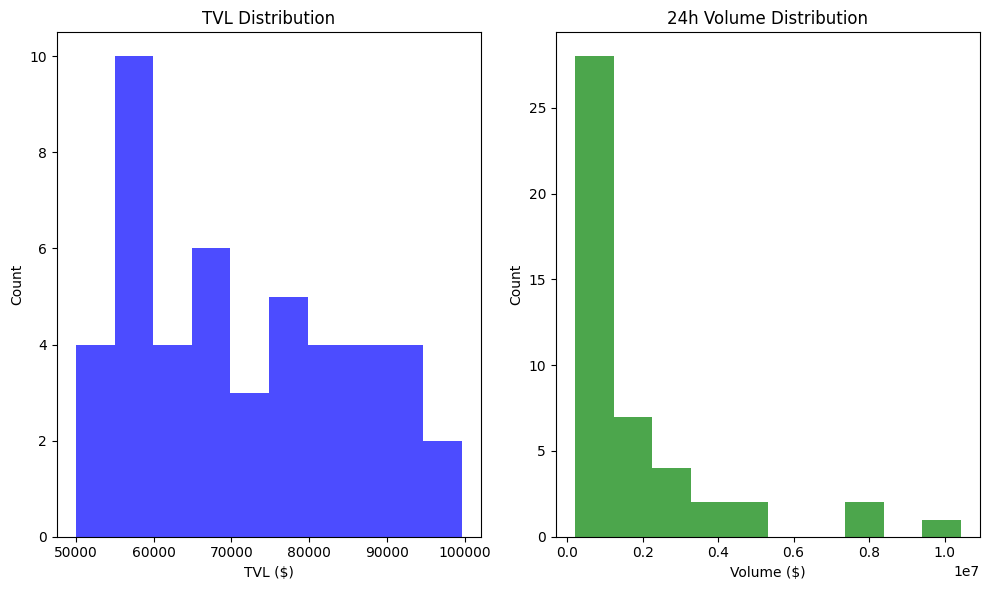

Loaded 46 pools for selection.


In [8]:
# Fetch pools function (refactored to use parameters)
def fetch_pools(selected_chains, selected_dexes, min_tvl, max_tvl, min_volume, no_pivots, no_stables, utility_pairs):
    current_date = datetime.now().strftime("%Y%m%d")
    
    if not selected_chains:
        print("No chains selected.")
        return None
    
    all_pools = []
    for chain in selected_chains:
        print(f"Processing chain: {chain}")
        chain_dexes = dexes_by_chain.get(chain, [])
        
        dexes_to_fetch = [dex for dex in chain_dexes if dex in selected_dexes] if selected_dexes else chain_dexes
        
        if not dexes_to_fetch:
            print(f"No DEXes to fetch for chain {chain}. Skipping.")
            continue
        
        for dex_name in dexes_to_fetch:
            print(f"Fetching from DEX: {dex_name} on chain {chain}")
            
            client = GeckoTerminalClient(
                network=chain,
                dex=dex_name
            )
            
            pools = client.fetch_liquidity_pools(
                all_pages=True,
                min_tvl=min_tvl,
                max_tvl=max_tvl,
                min_volume=min_volume,
                no_pivots=no_pivots,
                no_stables=no_stables,
                utility_pairs=utility_pairs
            )
            
            for pool in pools:
                pool.chain = chain
                pool.dex = dex_name
            
            all_pools.extend(pools)
            print(f"Fetched {len(pools)} pools from {dex_name} on {chain}")
    
    if not all_pools:
        print('No pools found matching the criteria.')
        return None
    
    print(f"Total pools before dedup: {len(all_pools)}")
    df = pd.DataFrame([
        {
            'Chain': pool.chain,
            'DEX': pool.dex,
            'Pair': f'{pool.token0_symbol}/{pool.token1_symbol}',
            'TVL': pool.tvl,
            '24hVolume': pool.volume,
            'Address': pool.address
        } for pool in all_pools
    ])
    
    # Drop duplicates: for same Chain, DEX, Pair, keep the one with highest Volume
    df = df.sort_values('24hVolume', ascending=False).drop_duplicates(subset=['Chain', 'DEX', 'Pair'])
    print(f"Total pools after dedup: {len(df)}")
    
    # Compute Volume/TVL ratio and add as a new column
    df['Volume_TVL_Ratio'] = df['24hVolume'] / df['TVL']
    
    # Filter by min_volume_tvl_ratio
    df = df[df['Volume_TVL_Ratio'] >= min_volume_tvl_ratio]
    print(f"Total pools after Volume/TVL ratio filter (>= {min_volume_tvl_ratio}): {len(df)}")
    
    print(f'Displaying {len(df)} pools (with Volume/TVL ratio):')
    display(df)
    
    output_file = f'pools_multi_{current_date}.csv'
    df.to_csv(output_file, index=False)
    print(f'Saved results (including Volume/TVL ratio) to {output_file}')
    
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df['TVL'], bins=10, color='blue', alpha=0.7)
    plt.title('TVL Distribution')
    plt.xlabel('TVL ($)')
    plt.ylabel('Count')
    plt.subplot(1, 2, 2)
    plt.hist(df['24hVolume'], bins=10, color='green', alpha=0.7)
    plt.title('24h Volume Distribution')
    plt.xlabel('Volume ($)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Update pool options (now just a list for next steps)
    pool_options = [f'{row["Chain"]}/{row["DEX"]}/{row["Pair"]} ({row["Address"][:8]}...)' for _, row in df.iterrows()]
    print(f"Loaded {len(pool_options)} pools for selection.")
    
    return df, pool_options

# Run pool fetching with parameters
pools_df, pool_options = fetch_pools(selected_chains, selected_dexes, min_tvl, max_tvl, min_volume, no_pivots, no_stables, utility_pairs)

## Fetch Price Data

This cell retrieves OHLCV data for selected liquidity pools (or all pools if specified) from the GeckoTerminal API. It checks for existing data to avoid redundant fetches, saves price data for base and quote tokens in USD and cross-token prices to CSV files, and filters out pools with less than 2 weeks of data. The filtered pool list is saved to `filtered_pools_YYYYMMDD.csv`.

In [9]:
# Price fetching function (refactored to use parameters)
def fetch_prices(pools_df, use_all_pools, selected_pools, force_redownload, start_timestamp, end_timestamp):
    current_date = datetime.now().strftime("%Y%m%d")
    pools_to_fetch = pool_options if use_all_pools else selected_pools
    
    if not pools_to_fetch:
        print('No pools selected for price fetching.')
        return None
    
    filtered_pools_df = pd.DataFrame()
    
    for pool_str in pools_to_fetch:
        parts = pool_str.split('/')
        if len(parts) < 3:
            print(f"Invalid pool format: {pool_str}. Skipping.")
            continue
        chain = parts[0]
        dex_name = parts[1]
        pair_address_str = '/'.join(parts[2:])
        pair = pair_address_str.split('(')[0].strip()
        address_abbrev = pair_address_str.split('(')[1][:-1].split('...')[0]
        
        print(f"Processing pool: {pool_str}")
        
        client = GeckoTerminalClient(network=chain, dex=dex_name)
        
        # Find the pool in df using abbreviated address to match
        pool_row = pools_df[(pools_df['Chain'] == chain) & (pools_df['DEX'] == dex_name) & (pools_df['Address'].str.startswith(address_abbrev))]
        if pool_row.empty:
            print(f"Pool not found in CSV: {pool_str}. Skipping.")
            continue
        address = pool_row['Address'].values[0]  # Use full address
        tvl = pool_row['TVL'].values[0]
        
        # Create date-based data folder
        data_folder = os.path.join('data', current_date, chain, dex_name, pair.replace('/', '_'))
        os.makedirs(data_folder, exist_ok=True)
        
        base_usd_path = os.path.join(data_folder, 'base_usd.csv')
        quote_usd_path = os.path.join(data_folder, 'quote_usd.csv')
        cross_path = os.path.join(data_folder, 'cross.csv')
        
        if not force_redownload and os.path.exists(base_usd_path) and os.path.exists(quote_usd_path) and os.path.exists(cross_path):
            print(f"Loading existing data for {pair} from {data_folder}")
            base_df = pd.read_csv(base_usd_path)
            quote_df = pd.read_csv(quote_usd_path)
            cross_df = pd.read_csv(cross_path)
        else:
            print(f"Fetching data for {pair}")
            base_usd_bars = client.get_price_bars(
                pool_address=address,
                timeframe='hour',
                aggregate=1,
                currency='usd',
                token='base',
                start_timestamp=start_timestamp,
                limit=1000
            )
            
            quote_usd_bars = client.get_price_bars(
                pool_address=address,
                timeframe='hour',
                aggregate=1,
                currency='usd',
                token='quote',
                start_timestamp=start_timestamp,
                limit=1000
            )
            
            cross_bars = client.get_price_bars(
                pool_address=address,
                timeframe='hour',
                aggregate=1,
                currency='token',
                token='base',
                start_timestamp=start_timestamp,
                limit=1000
            )
            
            if base_usd_bars and quote_usd_bars and cross_bars:
                base_df = base_usd_bars.data
                quote_df = quote_usd_bars.data
                cross_df = cross_bars.data
                
                base_df.to_csv(base_usd_path, index=False)
                quote_df.to_csv(quote_usd_path, index=False)
                cross_df.to_csv(cross_path, index=False)
                print(f"Saved data for {pair} to {data_folder}")
            else:
                print(f"Failed to fetch data for {pair}. Skipping.")
                continue
        
        # Check pool age (336 = hours in 2 weeks, only valid for hourly aggregation)
        if len(cross_df) < 336:
            print(f"Pool {pair} is too young (less than 2 weeks of data). Discarding.")
            continue
        
        cross_df['timestamp'] = pd.to_datetime(cross_df['timestamp'])
        time_span_hours = (cross_df['timestamp'].max() - cross_df['timestamp'].min()).total_seconds() / 3600
        if time_span_hours < 336:
            print(f"Pool {pair} data spans only {time_span_hours:.2f} hours (< 2 weeks). Discarding.")
            continue
        
        print(f"Added pool {pair} (age OK)")
        filtered_pools_df = pd.concat([filtered_pools_df, pool_row])
    
    if not filtered_pools_df.empty:
        filtered_file = f'filtered_pools_{current_date}.csv'
        filtered_pools_df.to_csv(filtered_file, index=False)
        print(f"Saved {len(filtered_pools_df)} filtered pools to {filtered_file}")
    else:
        print("No pools passed the age filter.")
    
    return filtered_pools_df

# Run price fetching with parameters (assumes pools_df from previous cell)
filtered_pools_df = fetch_prices(pools_df, use_all_pools, selected_pools, force_redownload, start_timestamp, end_timestamp)

Processing pool: solana/raydium/GrokCLI/SOL (B3zEeicg...)
Loading existing data for GrokCLI/SOL from data\20250722\solana\raydium\GrokCLI_SOL
Pool GrokCLI/SOL is too young (less than 2 weeks of data). Discarding.
Processing pool: solana/raydium/OpticXT/SOL (4NiCVAfw...)
Loading existing data for OpticXT/SOL from data\20250722\solana\raydium\OpticXT_SOL
Pool OpticXT/SOL is too young (less than 2 weeks of data). Discarding.
Processing pool: solana/raydium/Chloe/SOL (DainmLHo...)
Fetching data for Chloe/SOL
Saved data for Chloe/SOL to data\20250722\solana\raydium\Chloe_SOL
Pool Chloe/SOL is too young (less than 2 weeks of data). Discarding.
Processing pool: solana/raydium/TiA/SOL (AKT2onG6...)
Loading existing data for TiA/SOL from data\20250722\solana\raydium\TiA_SOL
Pool TiA/SOL is too young (less than 2 weeks of data). Discarding.
Processing pool: solana/raydium/Altman/SOL (FhTkfTRt...)
Loading existing data for Altman/SOL from data\20250722\solana\raydium\Altman_SOL
Pool Altman/SOL is

## Calculate Metrics and Analyze Pools

This cell calculates metrics for filtered pools, including average daily volume and fees for 3, 7, and 14 days using pool-specific fee tiers fetched from the GeckoTerminal API. It also computes volatility for the same periods. Results are saved in a DataFrame, and an LP opportunities report is generated based on specified thresholds (TVL, 7-day volume, 7-day fees). A price correlation matrix is computed and visualized as a heatmap.

DEBUG: Rows in data for last 3 days = 71
DEBUG: Rows in data for last 7 days = 144
DEBUG: Rows in data for last 14 days = 283
DEBUG: Rows in data for last 3 days = 73
DEBUG: Rows in data for last 7 days = 169
DEBUG: Rows in data for last 14 days = 337
DEBUG: Rows in data for last 3 days = 73
DEBUG: Rows in data for last 7 days = 169
DEBUG: Rows in data for last 14 days = 337
DEBUG: Rows in data for last 3 days = 73
DEBUG: Rows in data for last 7 days = 169
DEBUG: Rows in data for last 14 days = 337
DEBUG: Rows in data for last 3 days = 73
DEBUG: Rows in data for last 7 days = 169
DEBUG: Rows in data for last 14 days = 337
DEBUG: Rows in data for last 3 days = 73
DEBUG: Rows in data for last 7 days = 169
DEBUG: Rows in data for last 14 days = 337
DEBUG: Rows in data for last 3 days = 73
DEBUG: Rows in data for last 7 days = 169
DEBUG: Rows in data for last 14 days = 337
DEBUG: Rows in data for last 3 days = 73
DEBUG: Rows in data for last 7 days = 169
DEBUG: Rows in data for last 14 day

,3_days_avg_daily_volume,3_days_avg_daily_fees,3_days_avg_daily_fee_to_tvl_ratio,3_days_avg_daily_volume_to_tvl_ratio,7_days_avg_daily_volume,7_days_avg_daily_fees,7_days_avg_daily_fee_to_tvl_ratio,7_days_avg_daily_volume_to_tvl_ratio,14_days_avg_daily_volume,14_days_avg_daily_fees,...,14_days_avg_daily_volume_to_tvl_ratio,3_days_volatility,7_days_volatility,14_days_volatility,Chain,DEX,Pair,Address,TVL,FeeTier
0,4.127819e+05,1238.345692,0.013253,4.417672,2.009499e+05,602.849749,0.006452,2.150605,1.096858e+05,329.057258,...,1.173878,0.030235,0.029660,0.024844,solana,meteora,JupSOL/mSOL,7MAxiaoWkpsvJkKueMC4zCTVt7p5osMDtGxfCDZS488k,93438.7826,0.003
1,3.260377e+05,978.113075,0.013215,4.405035,2.318019e+05,695.405719,0.009395,3.131832,1.815907e+05,544.771971,...,2.453438,0.947176,0.755394,0.691401,solana,meteora,JUP/SOL,8nGw9VHzwTBLcAfxWYnFLWbind4tJPSAXiq8nB89mx9d,74014.7867,0.003
2,4.042606e+05,1212.781904,0.020678,6.892769,3.644213e+05,1093.263752,0.018640,6.213495,2.204914e+05,661.474224,...,3.759447,1.155072,1.402727,1.486531,solana,meteora,Bonk/SOL,sx7pZ2sFmZpwCZaatYojNKUfTdpb5EjwEAgNEH8KGz3,58649.9601,0.003
3,5.150272e+06,15450.817309,0.195878,65.292828,3.653406e+06,10960.219449,0.138949,46.316237,3.354215e+06,10062.645208,...,42.523224,18.086067,14.001668,12.171563,solana,meteora,Dege/SOL,J22tjJspw9nAm4zExb3AFNSKF3UAiQFXnqNtfmFvSjhK,78879.6047,0.003
4,3.447448e+05,1034.234279,0.015225,5.075014,2.982032e+05,894.609668,0.013170,4.389872,2.497360e+05,749.207907,...,3.676382,1.251505,1.351162,1.198558,solana,orca,Fartcoin/SOL,Tuy6gMupGQN7wCZ8rVP1EuLRYB132VSo9Smy4AJvQgn,67929.8175,0.003
5,3.234869e+05,970.460662,0.016459,5.486351,3.788152e+05,1136.445624,0.019274,6.424721,5.109325e+05,1532.797573,...,8.665437,4.825411,5.737486,6.422415,solana,meteora,URANUS/SOL,B8gaXBnU1SSLisCFJvDUq1eN7YfMAx8quwtvzCwntwjB,58962.1220,0.003
6,2.186412e+05,655.923558,0.012084,4.028120,2.530492e+05,759.147467,0.013986,4.662032,2.723751e+05,817.125290,...,5.018082,2.314553,2.983413,2.869552,solana,meteora,House/SOL,2KQLFXbAGiv2ZEiCTENwknkvUNk2Boy4LVVzByFGLt3s,54278.7213,0.003
7,2.237599e+05,671.279616,0.009893,3.297672,1.840578e+05,552.173525,0.008138,2.712561,1.305489e+05,391.646751,...,1.923971,1.197800,1.320469,1.172745,solana,meteora,Fartcoin/SOL,4Dvr3ghgphp4aTAsB34fmPP9Uk6e6xui6PbPaNiAHqRo,67853.8973,0.003
8,2.940558e+05,882.167363,0.010358,3.452547,2.252504e+05,675.751228,0.007934,2.644694,2.113563e+05,634.069031,...,2.481562,0.795065,0.756348,0.791326,solana,orca,PYTH/SOL,8erNF5u3CHrqZJXtkfY8CjSxFYF1yqHmN8uDbAhk6tWM,85170.6814,0.003
9,5.662821e+05,1698.846334,0.025541,8.513775,3.519353e+05,1055.806010,0.015874,5.291176,2.502686e+05,750.805918,...,3.762667,2.181269,1.772514,1.596315,solana,orca,WEN/SOL,7BZzoP3QB2zK3R7WqRzjS5fpeeErgdy3HGzxXrN97aEY,66513.6329,0.003


Generating LP Opportunities Report...
Found 13 LP opportunities:


,Chain,DEX,Pair,TVL,7_days_avg_daily_volume,7_days_avg_daily_fees,7_days_avg_daily_fee_to_tvl_ratio,7_days_avg_daily_volume_to_tvl_ratio,Address
0,solana,meteora,JupSOL/mSOL,93438.7826,2.009499e+05,602.849749,0.006452,2.150605,7MAxiaoWkpsvJkKueMC4zCTVt7p5osMDtGxfCDZS488k
1,solana,meteora,JUP/SOL,74014.7867,2.318019e+05,695.405719,0.009395,3.131832,8nGw9VHzwTBLcAfxWYnFLWbind4tJPSAXiq8nB89mx9d
2,solana,meteora,Bonk/SOL,58649.9601,3.644213e+05,1093.263752,0.018640,6.213495,sx7pZ2sFmZpwCZaatYojNKUfTdpb5EjwEAgNEH8KGz3
3,solana,meteora,Dege/SOL,78879.6047,3.653406e+06,10960.219449,0.138949,46.316237,J22tjJspw9nAm4zExb3AFNSKF3UAiQFXnqNtfmFvSjhK
4,solana,orca,Fartcoin/SOL,67929.8175,2.982032e+05,894.609668,0.013170,4.389872,Tuy6gMupGQN7wCZ8rVP1EuLRYB132VSo9Smy4AJvQgn
5,solana,meteora,URANUS/SOL,58962.1220,3.788152e+05,1136.445624,0.019274,6.424721,B8gaXBnU1SSLisCFJvDUq1eN7YfMAx8quwtvzCwntwjB
6,solana,meteora,House/SOL,54278.7213,2.530492e+05,759.147467,0.013986,4.662032,2KQLFXbAGiv2ZEiCTENwknkvUNk2Boy4LVVzByFGLt3s
7,solana,meteora,Fartcoin/SOL,67853.8973,1.840578e+05,552.173525,0.008138,2.712561,4Dvr3ghgphp4aTAsB34fmPP9Uk6e6xui6PbPaNiAHqRo
8,solana,orca,PYTH/SOL,85170.6814,2.252504e+05,675.751228,0.007934,2.644694,8erNF5u3CHrqZJXtkfY8CjSxFYF1yqHmN8uDbAhk6tWM
9,solana,orca,WEN/SOL,66513.6329,3.519353e+05,1055.806010,0.015874,5.291176,7BZzoP3QB2zK3R7WqRzjS5fpeeErgdy3HGzxXrN97aEY


Saved LP opportunities to lp_opportunities_20250722.csv
Starting correlation analysis...
Loaded 551 bars for JupSOL from saved data.
Loaded 720 bars for JUP from saved data.
Loaded 670 bars for Bonk from saved data.
Loaded 345 bars for Dege from saved data.
Loaded 720 bars for Fartcoin from saved data.
Loaded 442 bars for URANUS from saved data.
Loaded 720 bars for House from saved data.
Loaded 720 bars for Fartcoin from saved data.
Loaded 720 bars for PYTH from saved data.
Loaded 720 bars for WEN from saved data.
Loaded 701 bars for zBTC from saved data.
Loaded 366 bars for memecoin from saved data.
Loaded 338 bars for priceless from saved data.
Loaded 720 bars for KMNO from saved data.
Loaded 720 bars for MOBILE from saved data.
Correlation matrix based on 241 overlapping timestamps
Correlation Matrix:


,JupSOL,JUP,Bonk,Dege,Fartcoin,URANUS,House,Fartcoin,PYTH,WEN,zBTC,memecoin,priceless,KMNO,MOBILE
JupSOL,1.000000,0.017040,0.013835,0.321565,0.073243,-0.327014,-0.283471,0.074711,-0.034678,-0.378136,0.540607,-0.180302,-0.122456,-0.226679,-0.052393
JUP,0.017040,1.000000,0.703891,-0.671167,0.645295,-0.322709,0.399317,0.650341,0.805380,0.745663,-0.489635,0.169920,-0.736063,0.753541,0.697365
Bonk,0.013835,0.703891,1.000000,-0.526622,0.529872,-0.331214,0.620442,0.532791,0.617855,0.634157,-0.440325,-0.248253,-0.596536,0.493213,0.679307
Dege,0.321565,-0.671167,-0.526622,1.000000,-0.321367,-0.023537,-0.262468,-0.322148,-0.550152,-0.770359,0.546362,-0.225262,0.521402,-0.542321,-0.372067
Fartcoin,0.073243,0.645295,0.529872,-0.321367,1.000000,-0.389059,0.310147,0.999310,0.686416,0.515982,-0.333635,0.016977,-0.733551,0.684755,0.651554
URANUS,-0.327014,-0.322709,-0.331214,-0.023537,-0.389059,1.000000,-0.143724,-0.389616,-0.208774,-0.014916,-0.007932,0.026168,0.407303,-0.228795,-0.240731
House,-0.283471,0.399317,0.620442,-0.262468,0.310147,-0.143724,1.000000,0.311392,0.529687,0.528503,-0.578776,-0.332304,-0.403080,0.534826,0.589334
Fartcoin,0.074711,0.650341,0.532791,-0.322148,0.999310,-0.389616,0.311392,1.000000,0.691573,0.519924,-0.333948,0.017471,-0.736577,0.686485,0.656809
PYTH,-0.034678,0.805380,0.617855,-0.550152,0.686416,-0.208774,0.529687,0.691573,1.000000,0.819291,-0.463889,-0.074895,-0.779080,0.726766,0.876916
WEN,-0.378136,0.745663,0.634157,-0.770359,0.515982,-0.014916,0.528503,0.519924,0.819291,1.000000,-0.644909,0.002106,-0.594266,0.673353,0.738227


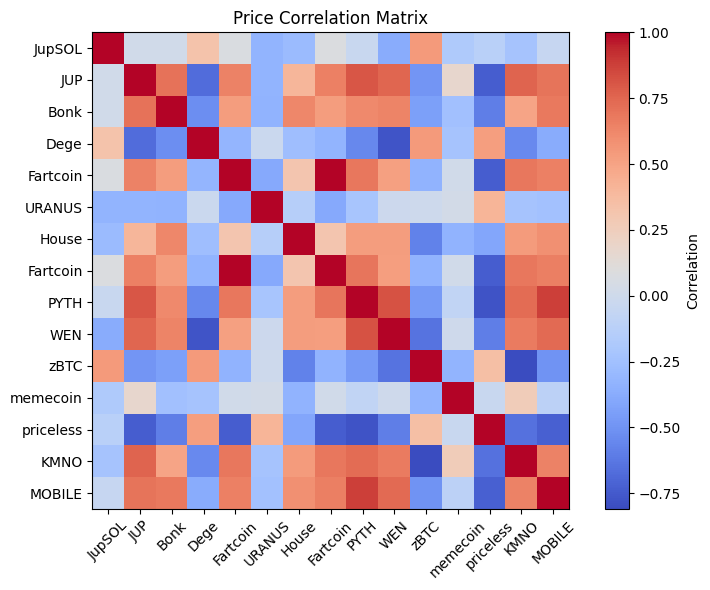

In [10]:
# Metrics calculation function (refactored to use parameters)
def calculate_metrics(filtered_pools_df, min_tvl_threshold, min_volume_threshold, min_fees_tvl_ratio_threshold, min_volume_tvl_ratio_threshold):
    current_date = datetime.now().strftime("%Y%m%d")
    
    # Fetch fee tiers for filtered pools
    pool_fee_dict = {}
    grouped = filtered_pools_df.groupby('Chain')
    for chain, group in grouped:
        addresses = group['Address'].tolist()
        # Assume dex is the same within group, take first
        dex_name = group['DEX'].iloc[0]
        client = GeckoTerminalClient(network=chain, dex=dex_name)
        multi_data = client.fetch_multiple_pools(addresses)
        for pool_data in multi_data:
            attr = pool_data.get('attributes', {})
            pool_addr = attr.get('address')
            fee_percentage = attr.get('pool_fee_percentage')
            if fee_percentage is None:
                fee_percentage = 0.3  # Default if None
            pool_fee_dict[pool_addr] = float(fee_percentage) / 100  # Convert percentage to decimal (e.g., 0.3 -> 0.003)
    
    metrics_list = []
    for _, row in filtered_pools_df.iterrows():
        chain = row['Chain']
        dex_name = row['DEX']
        address = row['Address']
        tvl = row['TVL']
        pair = row['Pair']
        token0_symbol, token1_symbol = pair.split('/')
        
        data_folder = os.path.join('data', current_date, chain, dex_name, f'{token0_symbol}_{token1_symbol}')
        base_usd_path = os.path.join(data_folder, 'base_usd.csv')
        quote_usd_path = os.path.join(data_folder, 'quote_usd.csv')
        cross_path = os.path.join(data_folder, 'cross.csv')
        
        if os.path.exists(base_usd_path) and os.path.exists(quote_usd_path) and os.path.exists(cross_path):
            base_df = pd.read_csv(base_usd_path)
            quote_df = pd.read_csv(quote_usd_path)
            cross_df = pd.read_csv(cross_path)
            
            fee_rate = pool_fee_dict.get(address, 0.003)  # Use fetched fee_rate or default
            
            metrics = calculate_pool_metrics(
                tvl=tvl,
                base_df=base_df,
                cross_price_df=cross_df,
                fee_rate=fee_rate
            )
            metrics['Chain'] = chain
            metrics['DEX'] = dex_name
            metrics['Pair'] = pair
            metrics['Address'] = address
            metrics['TVL'] = tvl
            metrics['FeeTier'] = fee_rate
            metrics_list.append(metrics)
        else:
            print(f"Data not found for {pair} on {chain}/{dex_name}. Skipping metrics.")
    
    if metrics_list:
        stats_df = pd.DataFrame(metrics_list)
        print("Pool Metrics:")
        display(stats_df)
        
        print("Generating LP Opportunities Report...")
        lp_opportunities = stats_df[
            (stats_df['TVL'] >= min_tvl_threshold) &
            (stats_df['7_days_avg_daily_volume'] >= min_volume_threshold) &
            (stats_df.get('7_days_avg_daily_fee_to_tvl_ratio', 0) >= min_fees_tvl_ratio_threshold) &
            (stats_df.get('7_days_avg_daily_volume_to_tvl_ratio', 0) >= min_volume_tvl_ratio_threshold)
        ]
        if not lp_opportunities.empty:
            print(f"Found {len(lp_opportunities)} LP opportunities:")
            display(lp_opportunities[['Chain', 'DEX', 'Pair', 'TVL', '7_days_avg_daily_volume', '7_days_avg_daily_fees', '7_days_avg_daily_fee_to_tvl_ratio', '7_days_avg_daily_volume_to_tvl_ratio', 'Address']])
            report_file = f'lp_opportunities_{current_date}.csv'
            lp_opportunities.to_csv(report_file, index=False)
            print(f"Saved LP opportunities to {report_file}")
        else:
            print("No LP opportunities found based on the specified thresholds.")
    else:
        print("No metrics calculated.")
    
    # Correlation analysis
    print("Starting correlation analysis...")
    data_list = []
    for _, row in filtered_pools_df.iterrows():
        chain = row['Chain']
        dex_name = row['DEX']
        pair = row['Pair']
        token_symbol = pair.split('/')[0]
        
        token0_symbol, token1_symbol = pair.split('/')
        data_folder = os.path.join('data', current_date, chain, dex_name, f'{token0_symbol}_{token1_symbol}')
        cross_path = os.path.join(data_folder, 'cross.csv')
        
        if os.path.exists(cross_path):
            cross_df = pd.read_csv(cross_path)
            data_list.append((token_symbol, cross_df))
            print(f"Loaded {len(cross_df)} bars for {token_symbol} from saved data.")
        else:
            print(f"Cross data not found for {pair}. Skipping.")
    
    if not data_list:
        print('No price data available.')
        return
    
    corr_matrix = compute_correlation_matrix_from_dataframes(data_list)
    if not corr_matrix.empty:
        print('Correlation Matrix:')
        display(corr_matrix)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
        plt.colorbar(label='Correlation')
        plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
        plt.yticks(range(len(corr_matrix)), corr_matrix.index)
        plt.title('Price Correlation Matrix')
        plt.tight_layout()
        plt.show()
    else:
        print('No correlation data available.')

# Run metrics calculation with parameters (assumes filtered_pools_df from previous cell)
calculate_metrics(filtered_pools_df, min_tvl_threshold, min_volume_threshold, min_fees_tvl_ratio_threshold, min_volume_tvl_ratio_threshold)

## Test Multi Pool Fetching

This cell tests the `fetch_multiple_pools` method of the GeckoTerminalClient by fetching data for a list of specified pool addresses on Ethereum's Uniswap V3. It prints the pool address, name, and fee percentage for each pool, verifying the API's multi-pool endpoint functionality.

In [6]:
# Test cell for multi pool fetching

# Import the client (assuming it's in your src folder)
from src.clients.geckoterminal import GeckoTerminalClient
from src.constants import Network

# Initialize the client for Solana and Meteora DEX (adjust if needed)
client = GeckoTerminalClient(network=Network.ETHEREUM.value, dex="uniswap_v3")

# Example list of pool addresses (use real addresses from your fetched pools)
pool_addresses = [
    "0xcb488b8452996454237d824d72f86090470292f4",  # Replace with actual pool address 1

]

# Fetch data for multiple pools
multi_pool_data = client.fetch_multiple_pools(pool_addresses)

# Print the results
if multi_pool_data:
    print("Fetched data for multiple pools:")
    for pool in multi_pool_data:
        attributes = pool.get('attributes', {})
        address = attributes.get('address', 'N/A')
        name = attributes.get('name', 'N/A')
        fee_percentage = attributes.get('pool_fee_percentage', 'N/A')
        print(f"{attributes}")
        print(f"Pool Address: {address}")
        print(f"Pool Name: {name}")
        print(f"Fee Percentage: {fee_percentage}%")
        print("-" * 40)
else:
    print("No data fetched for the provided pools.")

Fetched data for multiple pools:
{'base_token_price_usd': '0.168438233058188', 'base_token_price_native_currency': '0.00004545077866391073366923452965', 'quote_token_price_usd': '3679.83', 'quote_token_price_native_currency': '1.0', 'base_token_price_quote_token': '0.00004545077866', 'quote_token_price_base_token': '22001.8232777611', 'address': '0xcb488b8452996454237d824d72f86090470292f4', 'name': 'CPOOL / WETH 0.3%', 'pool_name': 'CPOOL / WETH', 'pool_fee_percentage': '0.3', 'pool_created_at': '2021-12-29T21:14:40Z', 'fdv_usd': '167364883.097543', 'market_cap_usd': '131486978.370072', 'price_change_percentage': {'m5': '0', 'm15': '0.39', 'm30': '1.02', 'h1': '0.18', 'h6': '-1.48', 'h24': '-7.46'}, 'transactions': {'m5': {'buys': 1, 'sells': 0, 'buyers': 1, 'sellers': 0}, 'm15': {'buys': 7, 'sells': 4, 'buyers': 6, 'sellers': 4}, 'm30': {'buys': 8, 'sells': 5, 'buyers': 7, 'sellers': 4}, 'h1': {'buys': 8, 'sells': 6, 'buyers': 7, 'sellers': 4}, 'h6': {'buys': 24, 'sells': 22, 'buyers'